#Download the dataset

####Copyright https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', train=True,
              download=True,
              transform=Compose([ToTensor(),
                                 Normalize(mean=(0.5,), std=(0.5,))]))

In [ ]:
img, label = mnist[0]
print('label:', label)
print(img[:, 10:15, 10:15])
torch.min(img), torch.max(img)

label: 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [ ]:
def denorm(x):
  out = (x + 1) / 2
  return out.clamp(0, 1)

Label: 5


(torch.Size([1, 28, 28]), torch.Size([28, 28]))

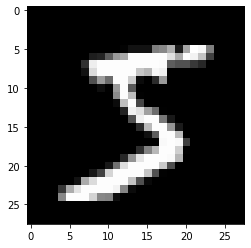

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)
img_norm.shape, img_norm[0].shape

In [ ]:
from torch.utils.data import DataLoader
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first_batch
torch.Size([100, 1, 28, 28])
tensor([0, 1, 3, 2, 6, 1, 0, 5, 4, 4, 6, 9, 7, 5, 3, 4, 3, 2, 6, 1, 2, 7, 6, 7,
        2, 0, 3, 8, 4, 0, 0, 1, 7, 7, 8, 2, 1, 3, 9, 9, 1, 8, 5, 5, 5, 4, 1, 3,
        4, 8, 4, 2, 6, 0, 3, 5, 8, 0, 2, 3, 8, 3, 2, 5, 5, 5, 0, 8, 0, 7, 0, 2,
        7, 1, 9, 1, 9, 6, 1, 2, 2, 0, 2, 5, 6, 3, 7, 1, 8, 7, 0, 3, 1, 3, 0, 4,
        7, 5, 2, 8])


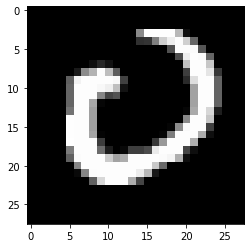

In [ ]:
for img_batch, label_batch in data_loader:
  print('first_batch')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0], cmap='gray')
  print(label_batch)
  break

In [ ]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

#Discrimintor Network

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
import torch.nn as nn
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [ ]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

#Generator Network


In [ ]:
latent_size = 64

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()

)

In [ ]:
#Generate random image using generator function
y = G(torch.randn(2, latent_size))
gen_imgs  = denorm(y.reshape((-1, 28, 28)).detach())

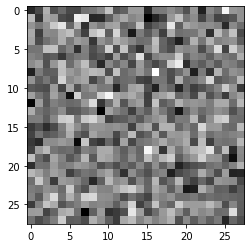

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray')

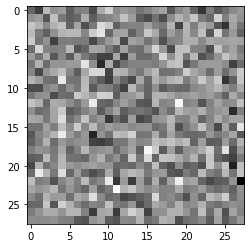

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray')

In [ ]:
G.to(device)
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

#Training the discriminator

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
#g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def reset_grads():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

def train_discriminator(images):
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)

  #Loss for real images 
  outputs = D(images)
  d_loss_real = criterion(outputs, real_labels)
  real_score = outputs

  #Loss for fake images
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs, fake_labels)
  fake_score = outputs

  #Combine the loss
  d_loss = d_loss_real + d_loss_fake
  #Reset the gradient
  reset_grads()
  #Compute the gradients
  d_loss.backward()
  #Adjust the parameters using backprop
  d_optimizer.step()
  return d_loss, real_score, fake_score



In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

#Generator training

In [ ]:
def train_generator():
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  labels = torch.ones(batch_size, 1).to(device)
  g_loss = criterion(D(fake_images), labels)

  #Backpropogation and optimization
  reset_grads()
  g_loss.backward()
  g_optimizer.step()
  return g_loss, fake_images

#Training the model


In [ ]:
import os
sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image
#Save some real images
for images, _ in data_loader:
  images = images.reshape(images.size(0), 1, 28, 28)
  save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
  break
Image(os.path.join(sample_dir, 'real_image.png'))

#Save fake images


In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
  fake_images = G(sample_vectors)
  fake__images = fake_images.reshape(fake_images.size(0), 1, 28,28)
  fake_name = 'fake_images-{0:0=4d}.png'.format(index)
  print('Saving', fake_name)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_name), nrow=10)

  #Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-000.png'))

Saving fake_images-0000.png


In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0563, g_loss: 4.2154, D(x): 0.98, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0772, g_loss: 5.3561, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [600/600], d_loss: 0.0461, g_loss: 4.8376, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0437, g_loss: 4.7652, D(x): 0.98, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.1360, g_loss: 5.0866, D(x): 0.98, D(G(z)): 0.10
Epoch [1/300], Step [600/600], d_loss: 0.8528, g_loss: 3.3303, D(x): 0.94, D(G(z)): 0.52
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2224, g_loss: 4.3491, D(x): 0.91, D(G(z)): 0.05
Epoch [2/300], Step [400/600], d_loss: 0.2815, g_loss: 3.8578, D(x): 0.93, D(G(z)): 0.12
Epoch [2/300], Step [600/600], d_loss: 0.3567, g_loss: 4.1044, D(x): 0.87, D(G(z)): 0.10
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.0205, g_loss: 1.4637, D(x): 0.75, D(G(z)): 0.37
Epoch [3/300], Step [400/6

In [ ]:
#Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

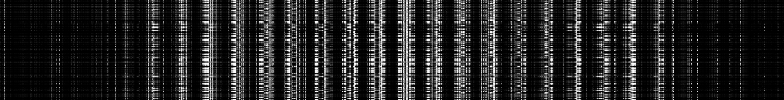

In [ ]:
Image('./samples/fake_images-0010.png')

In [ ]:
#Image('./samples/fake_images-0050.png')

In [ ]:
#Image('./samples/fake_images-0300.png')

Text(0.5, 1.0, 'Losses')

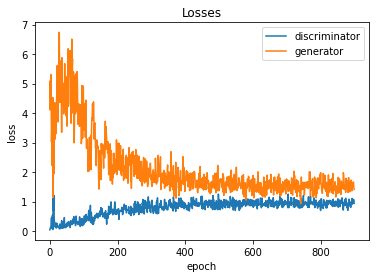

In [ ]:
#Plotting yhr losses for generator and discriminator
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['discriminator', 'generator'])
plt.title('Losses')

RuntimeError: ignored

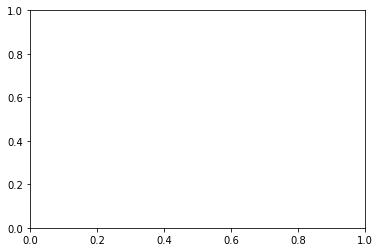

In [ ]:
#Plotting the real and fake score
plt.plot(real_score, '-')
plt.plot(fake_score, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real_score', 'Fake_score'])
plt.title('Scores')